In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import torch
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Анализ датасета.

In [ ]:
df = pd.read_csv('/content/FakeNewsNet.csv')
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [ ]:
df.isna().sum()

title              0
news_url         330
source_domain    330
tweet_num          0
real               0
dtype: int64

In [ ]:
df = df.dropna()

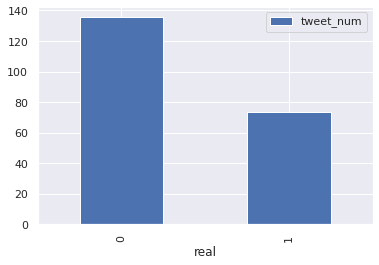

In [ ]:
df.groupby('real').mean().plot.bar()

Как видно на графике выше, фейковые отзывы в среднем имеют больше ретвитов.

# Предобработка.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 20.3 MB/s 
     |████████████████████████████████| 182 kB 74.3 MB/s 
     |████████████████████████████████| 7.6 MB 72.9 MB/s 


In [ ]:
import transformers as ppb 

In [ ]:
df = df[:2000] # из-за производительности используется не полный датасет

In [ ]:
df['real'].value_counts()

1    1537
0     463
Name: real, dtype: int64

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights).to(device)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenized = df['title'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 50)

In [ ]:
input_ids = torch.tensor(np.array(padded)).to(device)

with torch.no_grad():
    last_hidden_states = model(input_ids)

In [ ]:
features = last_hidden_states[0][:,0,:].cpu().numpy()

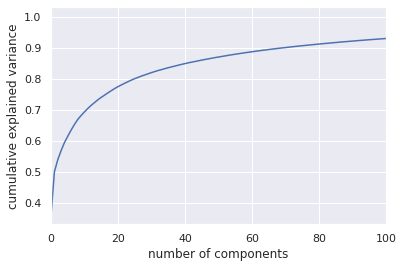

In [ ]:
from sklearn.decomposition import PCA

pca = PCA().fit(features)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.xlim(0, 100)
plt.ylabel('cumulative explained variance');

50 компонент содержат почти 90% объяснимой дисперсии.

In [ ]:
pca = PCA(20) 
projected = pca.fit_transform(features)
print(features.shape)
print(projected.shape)

(2000, 768)
(2000, 20)


Уменьшили количество компонент, найденных моделью DistilBERT с 768 до 20.

In [ ]:
from sklearn import preprocessing

source = df['source_domain']
real = df['real']
le = preprocessing.LabelEncoder()
le.fit(source)
source = le.transform(source)
result = np.vstack((projected.T, real.T, source.T)).T
result.shape

(2000, 22)

In [ ]:
labels = df['tweet_num']

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(result, labels, test_size=0.2)

# Прогноз популярности.

In [ ]:
lr = LinearRegression()
lr.fit(train_features, train_labels)

LinearRegression()

In [ ]:
lr.score(test_features, test_labels)

0.014095892667257748

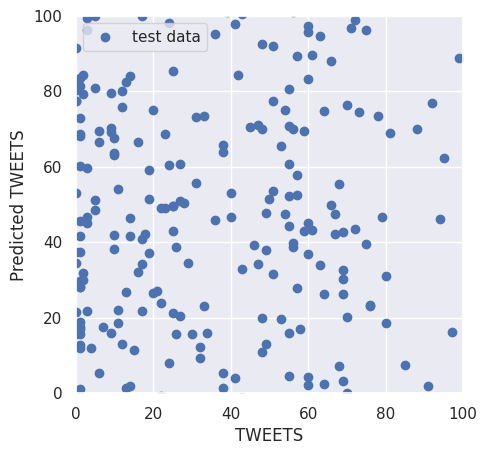

In [ ]:
plt.figure(figsize=(5, 5), dpi=100)
plt.xlabel("TWEETS")
plt.ylabel("Predicted TWEETS")
plt.xlim(0, 100)
plt.ylim(0, 100)
Y_test_pred = lr.predict(test_features)
plt.scatter(test_labels, Y_test_pred, lw=1, color="b", label="test data")
plt.legend()
plt.show()

In [ ]:
lasso = Lasso()
lasso.fit(train_features, train_labels)

Lasso()

In [ ]:
lasso.score(test_features, test_labels)

0.02930426468782321

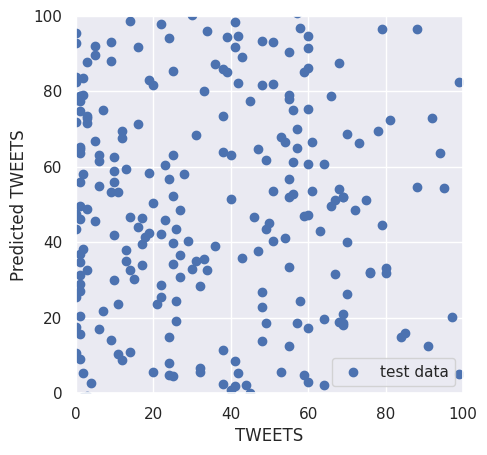

In [ ]:
plt.figure(figsize=(5, 5), dpi=100)
plt.xlabel("TWEETS")
plt.ylabel("Predicted TWEETS")
plt.xlim(0, 100)
plt.ylim(0, 100)
Y_test_pred = lasso.predict(test_features)
plt.scatter(test_labels, Y_test_pred, lw=1, color="b", label="test data")
plt.legend()
plt.show()

In [ ]:
ridge = Ridge()
ridge.fit(train_features, train_labels)

Ridge()

In [ ]:
ridge.score(test_features, test_labels)

0.014631500085840021

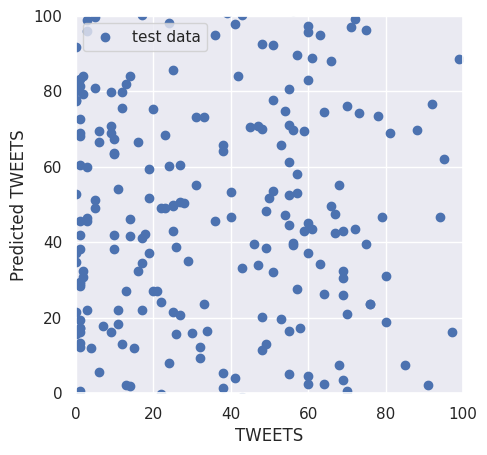

In [ ]:
plt.figure(figsize=(5, 5), dpi=100)
plt.xlabel("TWEETS")
plt.ylabel("Predicted TWEETS")
plt.xlim(0, 100)
plt.ylim(0, 100)
Y_test_pred = ridge.predict(test_features)
plt.scatter(test_labels, Y_test_pred, lw=1, color="b", label="test data")
plt.legend()
plt.show()

In [ ]:
en = ElasticNet()
en.fit(train_features, train_labels)

ElasticNet()

In [ ]:
en.score(test_features, test_labels)

0.03366770102288297

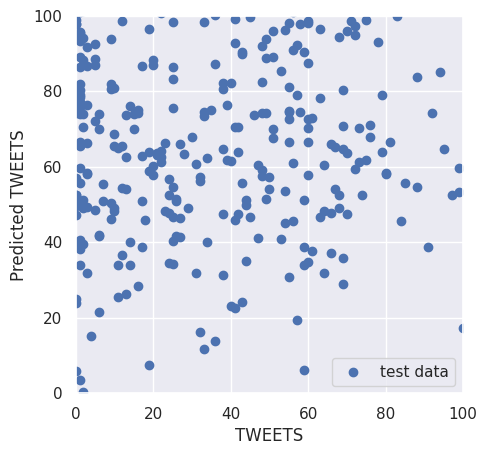

In [ ]:
plt.figure(figsize=(5, 5), dpi=100)
plt.xlabel("TWEETS")
plt.ylabel("Predicted TWEETS")
plt.xlim(0, 100)
plt.ylim(0, 100)
Y_test_pred = en.predict(test_features)
plt.scatter(test_labels, Y_test_pred, lw=1, color="b", label="test data")
plt.legend()
plt.show()

Корреляционная матрица признаков:

In [ ]:
df['source_domain'] = le.transform(df['source_domain'])
df.corr()

,source_domain,tweet_num,real
source_domain,1.000000,0.018167,-0.020283
tweet_num,0.018167,1.000000,-0.056226
real,-0.020283,-0.056226,1.000000
